# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, I am creating a hypothetical scenario for a concept that there may not be enough Italian Restaurants in Toronto Area. With the purpose in mind, finding the location to open such a restaurant is one of the most important decisions for this entrepreneur and I am designing this project to help him find the most suitable location.

In this project we will try to find the best locations to open this Italian restaurant. 
We will use our data science powers to find a few most promising neighbourhoods where there are not many Italian Restaurants yet. 

Our target stakeholders are businesspeople and investors that want to open an Italian restaurant in Toronto Canada.



## Data <a name="data"></a>

Following data sources will be used to get the required information:

1.	Wikipedia will be used scrap Toronto neighborhoods;
2.	Geospatial_Coordinates.csv will be used to get Latitude and Longitude information;
3.	Foursquare API will be used to get restaurants data related to these 2 cities.

In [1]:
# Package install
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans 

In [2]:
#We will use BeautifulSoup to get the zip code information of Canada from Wikipedia
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [4]:
#We save this to dataframe (df)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
# we see how many records we collected for this dataframe
df.shape

(103, 3)

In [6]:
#download Geospatial_Coordinates and put it in dataframe (df1)
URL = "https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv"
df1 = pd.read_csv("https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv")

# show the first 5 rows
df1.head ()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
#Rename Collum Postal Code
df1.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

#show the first 5 rows
df1.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
# Merge the 2 data sets (df and df1)
df2 = pd.merge(df, df1, on='PostalCode')

#show the first 5 rows
df2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name, and we'll make sure to detect and include all the subcategories of specific 'Italian restaurant' category, as we need info on Italian restaurants in the neighborhood.

Foursquare credentials are defined in hidden cell bellow.

In [9]:
CLIENT_ID = 'JKQMZRXFDVP5QYPF0ZJI2VPZFRXNS5RE03CBWK4O3LZFSO4A' #removed this for peer review
CLIENT_SECRET = '3XMAJSZJ32QD4FZMKD5F4IDID3SED3IYB3Q4PRG3ZA20P4ZG' #removed this for peer review
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [10]:
# Lets get the venue data from foursquare
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
#Create a dataset (df3)
df3 = getNearbyVenues(names = df2['Neighborhood'],
                                   latitudes = df2['Latitude'],
                                   longitudes = df2['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [12]:
# Let's see how many records
df3.shape

(2126, 7)

In [13]:
#get the dumies
to_onehot = pd.get_dummies(df3[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = df3['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2126, 274)


,Neighborhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Group by Neighborhoods
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(99, 274)


,Neighborhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Willowdale South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.030303,0.0,0.0,0.0,0.0,0.0,0.0
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
97,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#create a new data frame with only the italian restaurants (df4)
df4 = to_grouped[["Neighborhoods","Italian Restaurant"]]

#show the first 5 rows
df4.head ()

,Neighborhoods,Italian Restaurant
0,Agincourt,0.000
1,"Alderwood, Long Branch",0.000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000
3,Bayview Village,0.000
4,"Bedford Park, Lawrence Manor East",0.125


## Methodology <a name="methodology"></a>

The goal of this project is to come up with a simple study to identify area’s in the city of Toronto, where Italian Restaurants are located. So we can define areas of opportunities to invest / start an new Italian Restaurant. 


After that, it will be presented some number to justify the decision about which area has the most restaurant which helps us determine other area’s where we could start our restaurant.  

And finally, in the last part of this study, it is showed a map showing the spots where these Italian restaurants are located, and helps us to visualize the areas of opportunity for our restaurant. 

## Analysis <a name="analysis"></a>

First we have defined in the data stage the area's in toronto. Based on the information we extrated from wikipedia and combined this with some geograpic coordinates.

Secondly we extrated some data from foursquare and filtered this to only show the italian restaurants.

Now in this new dataset we want to determine custers to see if we can find area's where there are not many restaurants yet. We will do this with a type of analysis called K-Means. 

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. 

In [16]:
# cluster the above dataset into 3 clusters.
toclusters = 3
to_clustering = df4.drop(["Neighborhoods"], 1)
kmeans = KMeans(n_clusters=toclusters, random_state=1)
kmeans.fit_transform(to_clustering)
kmeans.labels_[0:20]

array([0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 2, 1, 0])

In [17]:
#create dataset (to_merged)
to_merged = df4.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [18]:
# Rename the columns
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged.head(5)

,Neighborhood,Italian Restaurant,Cluster Labels
0,Agincourt,0.000,0
1,"Alderwood, Long Branch",0.000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000,0
3,Bayview Village,0.000,0
4,"Bedford Park, Lawrence Manor East",0.125,1


In [19]:
# sort values  based on cluster labels
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

,Neighborhood,Italian Restaurant,Cluster Labels
0,Agincourt,0.0,0
67,"Regent Park, Harbourfront",0.0,0
66,Parkwoods,0.0,0
65,"Parkview Hill, Woodbine Gardens",0.0,0
62,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.0,0


In [20]:
#Combine the sets and set index
to_merged = to_merged.join(df3.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2126, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.79420,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.79420,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.79420,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.79420,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
67,"Regent Park, Harbourfront",0.0,0,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery


In [21]:
# sort on Cluster Labels
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
5,Berczy Park,0.0,0,43.644771,-79.373306,Starbucks,43.644489,-79.368639,Coffee Shop
5,Berczy Park,0.0,0,43.644771,-79.373306,Chotto Matte,43.646473,-79.378782,Japanese Restaurant
5,Berczy Park,0.0,0,43.644771,-79.373306,St. Lawrence Market Plaza,43.649169,-79.372330,Art Gallery
5,Berczy Park,0.0,0,43.644771,-79.373306,Balzac's Coffee,43.648457,-79.371790,Café


## Results <a name="results"></a>

Now that we have create the clusters with K-means we want first find out in which cluster are the least amount of Italian restaurants. So we know where to invest.

First let's visualize our findings Cluster 0 = red, Cluster 1 = blue, cluster 2 = green

In [22]:
# find the coordinates of the area
neighborhood_latitude = df2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df2.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [23]:
#Build the map
map_clusters = folium.Map(location=[43.7532586, -79.3296565],zoom_start=14)

# set color scheme for the clusters


# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
markers_colors[3] = 'yellow'
markers_colors[4] = 'cyan'
markers_colors[5] = 'black'
for lat, lon, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Cluster Labels']):
    
    
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
       
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We are going to create 3 new data sets 1 for each cluster

In [24]:
#Cluster 0
dfcluster0 = to_merged.loc[(to_merged['Cluster Labels'] ==0) & (to_merged['Venue Category'] == 'Italian Restaurant') ]

In [25]:
#Cluster 1
dfcluster1 = to_merged.loc[(to_merged['Cluster Labels'] ==1) & (to_merged['Venue Category'] == 'Italian Restaurant') ]

In [26]:
#Cluster 2
dfcluster2 = to_merged.loc[(to_merged['Cluster Labels'] ==2) & (to_merged['Venue Category'] == 'Italian Restaurant') ]

Let's see the amount of restaurants in each cluster 

In [27]:
dfcluster0.shape

(2, 9)

In [28]:
dfcluster1.shape

(16, 9)

In [29]:
dfcluster2.shape

(28, 9)

So we have 1 restaurants in cluster 0, 7 in cluster 1, and 38 in cluster 2.

Let's Put this in a dataframe and create a bar chart

In [36]:
# create dataframe (restaurants)
restaurants = {'Location': ['0','1','2'],
        'Number of restaurants': [2,16,28]
        }

dfrestaurants = pd.DataFrame(restaurants, columns = ['Location', 'Number of restaurants'])

print (dfrestaurants)

  Location  Number of restaurants
0        0                      2
1        1                     16
2        2                     28


<function matplotlib.pyplot.show(close=None, block=None)>

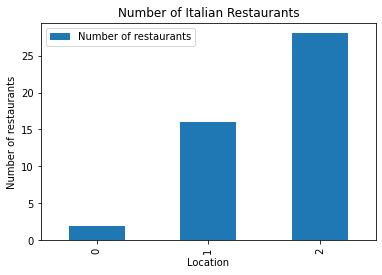

In [37]:
#import Mathplotlib
import matplotlib.pyplot as plt

# plot a bar chart
dfrestaurants.plot (kind= 'bar')

plt.title('Number of Italian Restaurants')
plt.xlabel('Location')
plt.ylabel('Number of restaurants')

plt.show

## Results and Discussion <a name="results"></a>

We can see that segment 0 has the least number of restaurants. Therefore, we want to be in this area.

In [38]:
# create dataset cluster 0
area0 = to_merged.loc[(to_merged['Cluster Labels'] ==0) ]

# remove dublicates
area0 = area0.drop_duplicates(subset=['Neighborhood'])

# display amount of area's
area0.shape

(76, 9)

Cluster 0 has the least amound of restaurant but there 1 only one area. Cluster 1 has 7 restaurants in 78 area's. Therefore the best is to be in cluster 1. Let's see which area's this is.

In [40]:
# download excel file to user as Appendix in report

# create excel writer object
writer = pd.ExcelWriter('area0.xlsx')
# write dataframe to excel
area0.to_excel(writer)
# save the excel
writer.save()
print('DataFrame is written successfully to Excel File.')
    

DataFrame is written successfully to Excel File.


In [41]:
# visualize this with a world map of the area.

# create the map
map_clusters = folium.Map(location=[43.7532586, -79.3296565],zoom_start=14)

# set color scheme for the clusters


# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
markers_colors[3] = 'yellow'
markers_colors[4] = 'cyan'
markers_colors[5] = 'black'
for lat, lon, cluster in zip(area0['Neighborhood Latitude'], area0['Neighborhood Longitude'], area0['Cluster Labels']):
    
    
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
       
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Most of the Italian restaurants are in cluster 1 lowest in Cluster 0.
Looking at nearby venues it seems cluster 1 might be a good location as there are not a lot of Italian restaurants in these areas. We therefore recommend the entrepreneur to open an authentic Italian restaurant in these locations. If we look to the total map of all the area’s 

In [ ]:
We might want to explorer the areas close to the blue and green areas first because there are likely to be more downtown.